## Greddy Agent

We want to create an agent that will find the action with the highest expected reward. One way an agent could operate is to always choose the action with the highest value based on the agent’s current estimates. This is called a greedy agent as it greedily chooses the action that it thinks has the highest value. Let's look at what happens in this case.

In [1]:
import numpy as np
import main_agent
import matplotlib.pyplot as plt
from rl_glue import RLGlue
import ten_arm_env
from tqdm import tqdm

In [2]:
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index
    of the item with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top = float("-inf")
#     print(f"TOP : {top}")
    ties = []
    
    for i in range(len(q_values)):
        # if a value in q_values is greater than the highest value, then update top and reset ties to zero
        # if a value is equal to top value, then add the index to ties (hint: do this no matter what)
        # return a random selection from ties. (hint: look at np.random.choice)
        if q_values[i] > top:
            top = q_values[i]
            ties = [i]
        elif q_values[i] == top:
            ties.append(i)
#     print(f"Ties : {ties}")
    return ties[np.random.choice(len(ties))]

In [3]:
# Do not modify this cell
# Test for Argmax Function
def test_argmax(): 
    test_array = [1, 0, 0, 1]
    total = 0
    for i in range(100):
#         print(argmax(test_array))
        total += argmax(test_array)
#         if i ==5:
#             break
    np.save("argmax_test", total)
    return total
test_argmax()

150

Now we introduce the first part of an RL-Glue agent that you will implement. Here we are going to create a GreedyAgent and implement the agent_step method. This method gets called each time the agent takes a step. The method has to return the action selected by the agent. This method also ensures the agent’s estimates are updated based on the signals it gets from the environment

In [4]:
# Greedy agent here [Graded]
class GreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent received from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this for this assignment 
        as you will not use it until future lessons.
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        ### Useful Class Variables ###
        # self.q_values : An array with the agent’s value estimates for each action.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step.
        #######################
        
        current_action = argmax(self.q_values)
        
        # Update action values. Hint: Look at the algorithm in section 2.4 of the textbook.
        # Increment the counter in self.arm_count for the action from the previous time step
        # Update the step size using self.arm_count
        # Update self.q_values for the action from the previous time step
       
        self.arm_count[self.last_action] += 1
        step_size = 1 / self.arm_count[self.last_action]
        old_estimate = self.q_values[self.last_action]
        self.q_values[self.last_action] = old_estimate + step_size * (reward - old_estimate)
    
        self.last_action = current_action
        
        return current_action
        

In [5]:
# Test for Greedy Agent Code
greedy_agent = GreedyAgent()
greedy_agent.q_values = [0, 0, 1.0, 0, 0]
greedy_agent.arm_count = [0, 1, 0, 0, 0]
greedy_agent.last_action = 1
action = greedy_agent.agent_step(1, 0)
np.save("greedy_test", greedy_agent.q_values)
print("Output:")
print(greedy_agent.q_values)
print("Expected Output:")
print([0, 0.5, 1.0, 0, 0])

Output:
[0, 0.5, 1.0, 0, 0]
Expected Output:
[0, 0.5, 1.0, 0, 0]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 41.70it/s]


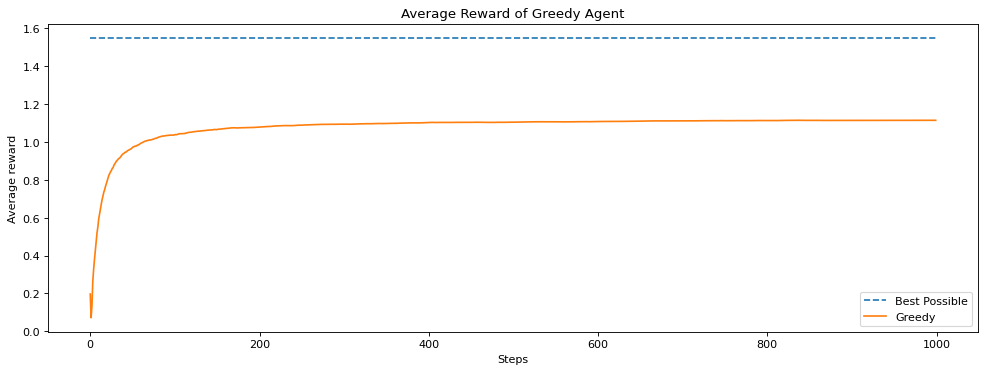

In [6]:
# Plot Greedy Result
num_runs = 200                    # The number of times we run the experiment
num_steps = 1000                  # The number of steps each experiment is run for
env = ten_arm_env.Environment     # We the environment to use
agent = GreedyAgent               # We choose what agent we want to use
agent_info = {"num_actions": 10}  # Pass the agent the information it needs; 
                                  # here it just needs the number of actions (number of arms).
env_info = {}                     # Pass the environment the information it needs; in this case, it is nothing.

all_averages = []

for i in tqdm(range(num_runs)):           # tqdm is what creates the progress bar below once the code is run
    rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
    rl_glue.rl_init(agent_info, env_info) # Pass RLGlue what it needs to initialize the agent and environment
    rl_glue.rl_start()                    # Start the experiment

    scores = [0]
    averages = []
    
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible", "Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)
np.save("greedy_scores", greedy_scores)

## Epsilon-Greedy Agent

We learned about another way for an agent to operate, where it does not always take the greedy action. Instead, sometimes it takes an exploratory action. It does this so that it can find out what the best action really is. If we always choose what we think is the current best action is, we may miss out on taking the true best action, because we haven't explored enough times to find that best action.

In [7]:
# Epsilon Greedy Agent here [Graded]
class EpsilonGreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent received from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this for this assignment 
        as you will not use it until future lessons.
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        ### Useful Class Variables ###
        # self.q_values : An array with the agent’s value estimates for each action.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step.
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        #######################
        
        # Choose action using epsilon greedy
        # Randomly choose a number between 0 and 1 and see if it is less than self.epsilon
        # (Hint: look at np.random.random()). If it is, set current_action to a random action.
        # Otherwise choose current_action greedily as you did above.
       
        if np.random.random() < self.epsilon:
            current_action = np.random.randint(0, len(self.q_values))
        else:
            current_action = argmax(self.q_values)
        
        # Update action-values - this should be the same update as your greedy agent above

        self.arm_count[self.last_action] += 1
        step_size = 1 / self.arm_count[self.last_action]
        old_estimate = self.q_values[self.last_action]
        self.q_values[self.last_action] = old_estimate + step_size * (reward - old_estimate)

        
        self.last_action = current_action
        
        return current_action

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 40.63it/s]


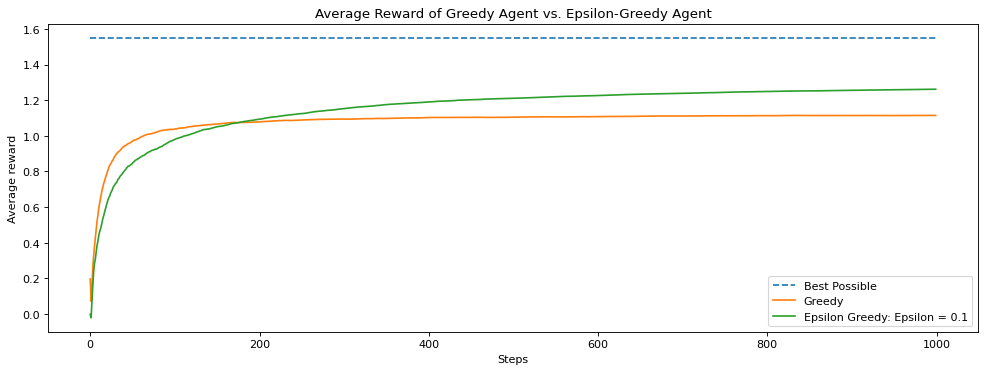

In [8]:
# Plot Epsilon greedy results and greedy results
num_runs = 200
num_steps = 1000
epsilon = 0.1
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": epsilon}
env_info = {}
all_averages = []

for i in tqdm(range(num_runs)):
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    averages = []
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.title("Average Reward of Greedy Agent vs. Epsilon-Greedy Agent")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(("Best Possible", "Greedy", "Epsilon Greedy: Epsilon = 0.1"))
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()
np.save("e-greedy", all_averages)